In [ ]:
# Install core PyTorch and torch_geometric
%pip install torch torchvision torchaudio
%pip install torch-geometric


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [2]:
# Create a tiny graph: 3 nodes, 2 edges
import torch
from torch_geometric.data import Data

# Edge list: node 0 → 1 and 1 → 2
edge_index = torch.tensor([[0, 1], [1, 2]], dtype=torch.long).t()

# Node features: one feature per node
x = torch.tensor([[1], [2], [3]], dtype=torch.float)

# Create graph data object
data = Data(x=x, edge_index=edge_index)

print(data) # Should print: Data(x=[3, 1], edge_index=[2, 2]) -> [3, 1] means that the node feature matrix x has 3 rows for the 3 nodes and 1 column as we have 1 feature per node; [2, 2], the edge list tensor, means that we have 2 rows (source and target node idx) and 2 columns (we have 2 edges in this graph)


Data(x=[3, 1], edge_index=[2, 2])


In [5]:
# Built-in graph dataset: KarateClub
from torch_geometric.datasets import KarateClub

# Load the dataset
dataset = KarateClub()
data = dataset[0]

# Explore the graph
print("Node feature shape:", data.x.shape)
print("Edge index shape:", data.edge_index.shape)
print("Labels shape:", data.y.shape)

# output will be:
# Node feature shape: torch.Size([34, 34]) -> each node is represented with a one-hot encoded vector: node 0 has [1, 0, 0, ..., 0], node 1 has [0, 1, 0, ..., 0], etc.
# Edge index shape: torch.Size([2, 156]) 2 rows -> row 0: source node indices, row 1: target node indices; 156 columns -> each column is a single edge; this dataset is undirected so even though we have 78 edges, we'll get 156 entries in this list
# Labels shape: torch.Size([34]) each node has one label, and there are 34 nodes -> community assignment — either: 0 for one club/community, 1 for the other

# Goal: predict the label for each node based on the graph and features


Node feature shape: torch.Size([34, 34])
Edge index shape: torch.Size([2, 156])
Labels shape: torch.Size([34])


In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv  # Graph Convolutional Network

class GCN(nn.Module): # Define a custom class GCN that inherits from nn.Module (required for any PyTorch model)
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 4)  # Hidden layer -> first GCN layer with 34-dimensional input (node features) and 4-dimensional hidden feature output, for each node: transforms x ∈ ℝ³⁴ → ℝ⁴
        self.conv2 = GCNConv(4, dataset.num_classes)   # Output layer -> second GCN layer with 4-dimensional input from conv1 and 4-dimensional output (4 classes in KarateClub) -> used to classify each node into one of the 4 classes

    def forward(self, data):  # Forward pass: defines what happens when you pass data through model(data)
        x, edge_index = data.x, data.edge_index # node features and graph connections
        x = self.conv1(x, edge_index) # Apply the first graph convolution layer
        x = F.relu(x) # ReLU activation to add non-linearity
        x = self.conv2(x, edge_index) # Apply the second graph convolution layer
        return F.log_softmax(x, dim=1)  # So output is in log-probability form

# Instantiate model
model = GCN() # Model instantiation
print(model)
# Output should be:
#GCN(
#  (conv1): GCNConv(34, 4)
#  (conv2): GCNConv(4, 4)
#)
# Graph has two convolutional layers
# conv1 takes input of size 34 and outputs size 4
# conv2 takes input of size 4 and outputs size 4


GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
)


In [17]:
print("Training labels:")
for idx in [0, 5, 10, 15]:
    print(f"Node {idx}: class {data.y[idx].item()}")  # these nodes are actually only of three classes, so one of the classes won't be trained on!


Training labels:
Node 0: class 1
Node 5: class 3
Node 10: class 3
Node 15: class 0


In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Adam -> gradient descent optimizer for model's weights (uses computed gradients)
loss_fn = torch.nn.NLLLoss()

# Train on 4 nodes only — one per class -> ISSUE (see cell above)
# data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool) # Creates Boolean mask of shape [34] (one entry per node in the graph). All values are initially False, meaning no node is being used for training yet
# data.train_mask[0] = True   # node with class 0 -> manually marking just one node for each class (0 to 3) to be used in training
# data.train_mask[5] = True   # node with class 1 -> model will use the features and labels of only these 4 nodes to learn
# data.train_mask[10] = True  # class 2
# data.train_mask[15] = True  # class 3

# Find one node per class
train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
for class_label in range(dataset.num_classes):
    idx = (data.y == class_label).nonzero(as_tuple=True)[0][0]  # First node with this class
    train_mask[idx] = True

data.train_mask = train_mask

for epoch in range(201):
    model.train() # switches the model into training mode (In such simple setups, calling model.train() or model.eval() won’t have any visible effect. But it's best practice to always use them in real projects, especially when your model includes stochastic behavior during training)
    optimizer.zero_grad() # resets gradients from previous iteration (otherwise gradients from mutliple backward passes will add up -> like this only the current gradient is used to update the weights)
    out = model(data)  # Forward pass: predict from data
    loss = loss_fn(out[data.train_mask], data.y[data.train_mask])  # Only on labeled nodes -> compute loss
    loss.backward() # Compute gradients
    optimizer.step()  # Update weights using gradients

    # Optional: print every 20 epochs
    if epoch % 20 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}') # Loss: how far off the model’s predictions are from the true labels; the lower the better the predictions

Epoch 000, Loss: 1.4309
Epoch 020, Loss: 0.7912
Epoch 040, Loss: 0.4761
Epoch 060, Loss: 0.2819
Epoch 080, Loss: 0.1874
Epoch 100, Loss: 0.1378
Epoch 120, Loss: 0.1053
Epoch 140, Loss: 0.0821
Epoch 160, Loss: 0.0655
Epoch 180, Loss: 0.0534
Epoch 200, Loss: 0.0446


In [20]:
model.eval()  # -> disables randomness and uses learned stats to show how well the model does on all nodes overall (including those it hasn't seen during training)
_, pred = model(data).max(dim=1)  # Choose class with highest log-prob; model(data) -> model’s output for each node ([34 × 4] matrix (34 nodes, 4 class scores each)); .max(dim=1) picks the class with the highest log-probability for each node -> pred (predicted class for each node-> tensor of shape [34]); _ is the actual max value (the log-prob itself), which we don’t need here

correct = int((pred == data.y).sum()) # compares each predicted label with the ground truth label data.y; sum adds up all 'True' predictions -> number of correct predictions
acc = correct / data.num_nodes  # what fraction of all nodes were predicted correctly
print(f'Accuracy: {acc:.4f}')


Accuracy: 0.8529


/tmp/ipython-input-21-3291321915.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Set2', dataset.num_classes),
/tmp/ipython-input-21-3291321915.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('Set2', dataset.num_classes),


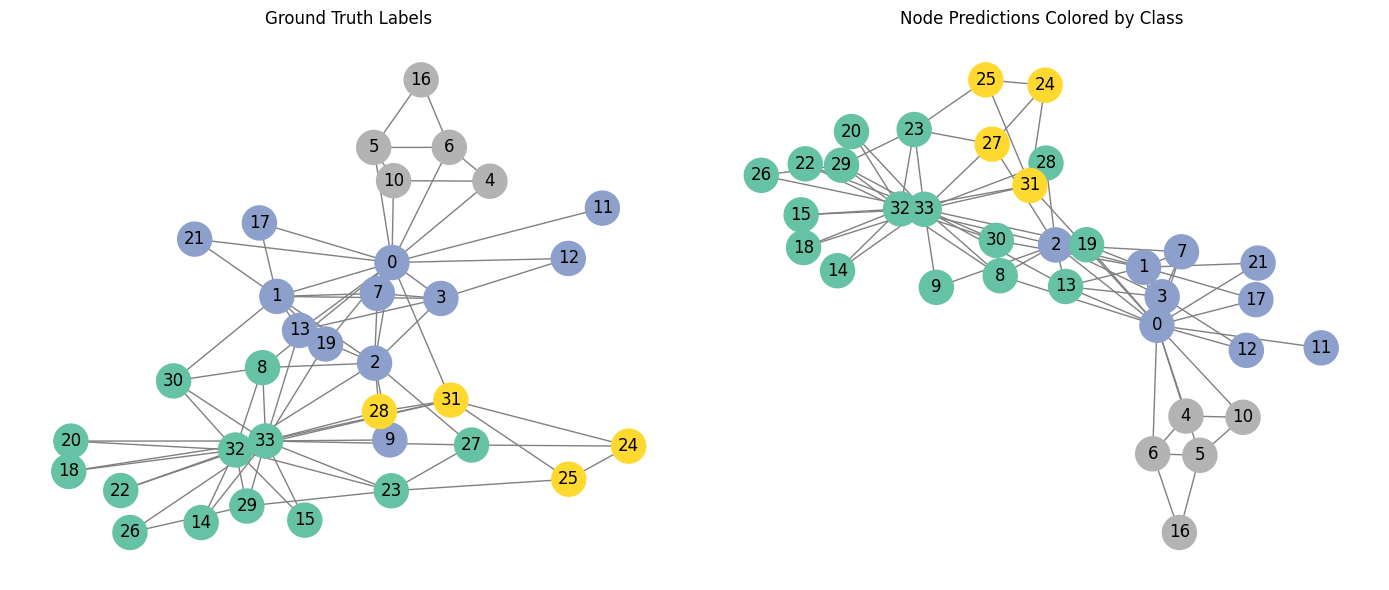

In [21]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Convert the PyG data to a NetworkX graph
G = to_networkx(data, to_undirected=True)

# Define node colors based on predicted class
# Get ground truth and predicted labels
true_labels = data.y.tolist()
node_colors = pred.tolist()  # Convert tensor to list of integers (class indices) (1 per node)

# Plot the graph
plt.figure(figsize=(14, 6))
# --- Plot 1: Ground Truth ---
plt.subplot(1, 2, 1)
nx.draw(
    G,
    with_labels=True,
    node_color=true_labels,
    cmap=plt.cm.get_cmap('Set2', dataset.num_classes),
    node_size=600,
    font_color='black',
    edge_color='gray'
)
plt.title("Ground Truth Labels")

# --- Plot 2: Model Predictions ---
plt.subplot(1, 2, 2)
nx.draw(
    G,
    with_labels=True,
    node_color=node_colors,
    cmap=plt.cm.get_cmap('Set2', dataset.num_classes),
    node_size=600,
    font_color='black',
    edge_color='gray'
)
plt.title("Node Predictions Colored by Class")


plt.tight_layout()
plt.show()
